In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import networkx as nx

In [2]:
expression_sc = pd.read_csv("../../CAR_data/log_sc_expr_with_celltypes.csv", index_col = 0)
expression_noise = pd.read_csv("../../CAR_data/log_sc_expr_with_celltypes_with_noise.csv", index_col = 0)
TFs = pickle.load(open("../../CAR_data/TF_list", "rb"))
TFs.remove("AP1") # This is a complex we don't have its expression

In [3]:
# The manual network (without GRN)
df = pd.read_csv('../../CAR_data/Network_without_GRN.tsv', sep = "\t", header=None)
df.columns = ["source", "target", "weight"]
Graphtype = nx.DiGraph()
G_noGRN = nx.from_pandas_edgelist(df, create_using=Graphtype)

In [4]:
complexes = ['AP1', 'NFkB', 'TRAF12', 'TRAF23', 'STAT35']
# We predict from the nodes that are not TF and are not complexes (We don't have expression of complexes)
predictors = [n for n in G_noGRN.nodes() if (n not in TFs and n not in complexes)]


# Train a random forest on the whole network for each TF

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [6]:
## Create the training and test split
# We'll test both the traditional pipeline data and the data with added Poisson noise
train_val_split = train_test_split(expression_sc, test_size=0.2, random_state=1)
expression_training_sc = train_val_split[0]
expression_validation_sc = train_val_split[1]

train_val_split = train_test_split(expression_noise, test_size=0.2, random_state=1)
expression_training_noise = train_val_split[0]
expression_validation_noise = train_val_split[1]

## Check that all domains are represented in the training sets
n_CAR = np.unique(expression_training_sc["CAR_Variant"])
print(f"There are {len(n_CAR)}/31 CAR Variants in the mixed training set")
n_CAR = np.unique(expression_training_noise["CAR_Variant"])
print(f"There are {len(n_CAR)}/31 CAR Variants in the mixed training set")
       

There are 31/31 CAR Variants in the mixed training set
There are 31/31 CAR Variants in the mixed training set


In [7]:
# Fit a scaler to each of the datasets

genes = [c for c in expression_sc.columns]
genes.remove("CAR_Variant")
genes.remove("Type")
genes.remove("cell_type")

scaler = MinMaxScaler()
expression_training_sc[genes] = scaler.fit_transform(expression_training_sc[genes])
expression_validation_sc[genes] = scaler.transform(expression_validation_sc[genes])

scaler_noise = MinMaxScaler()
expression_training_noise[genes] = scaler_noise.fit_transform(expression_training_noise[genes])
expression_validation_noise[genes] = scaler_noise.transform(expression_validation_noise[genes])

In [12]:
def fit_random_forest(TFs, predictors, expression_train, expression_valid, plot = False):
    """ Fit a random forest to each TF and create a dictionary to save the results."""
    score_dict = {}
    unfit = []
    for tf in TFs:
        print(tf)
        rf = RandomForestRegressor(random_state=2)


        try:
            # Train the forest
            rf.fit(X = expression_train[predictors],
                   y = expression_train[tf])
            
        except BaseException as e:
            print(f"{tf} could not be fit")
            print(e)
            unfit.append(tf)
            continue

        ## For each model that was fit: predict and assess fit on the training and validation set
        ypred_test = rf.predict(expression_valid[predictors])
        ypred_train = rf.predict(expression_train[predictors])



        score_train = r2_score(y_true=expression_train[tf],
                                             y_pred = ypred_train)
        score_test = r2_score(y_true=expression_valid[tf],
                                             y_pred = ypred_test)
        score_dict[tf] = (score_train, score_test)
        print(plot)
        if plot:
            plt.figure()
            plt.scatter(x = expression_valid[tf], y = ypred_test)
            X = np.linspace(0,1)
            plt.plot( X, X, "r")
            plt.title( f" Transcription factor :{tf} \n Train R2:{score_train}, Test R2:{score_test}")
            plt.show()
        else:
            print(f" TF:{tf}, Train R2:{score_train}, Test R2:{score_test}")




    return(score_dict, unfit)

In [13]:
plt.close("all")

ATF1
True


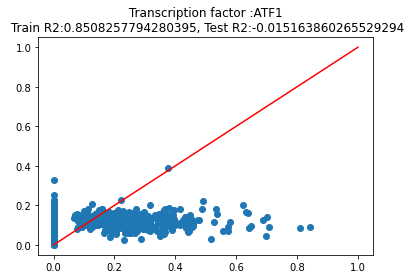

ATF2
True


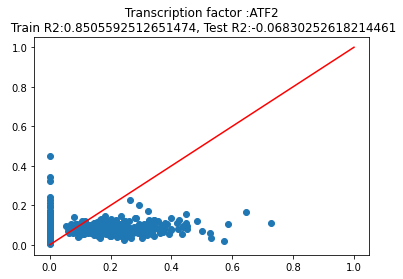

BCL3
True


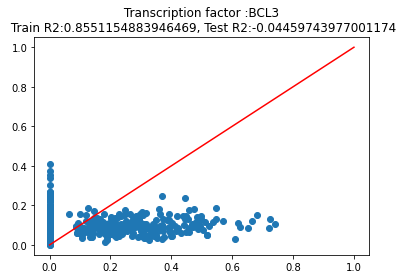

CEBPB
True


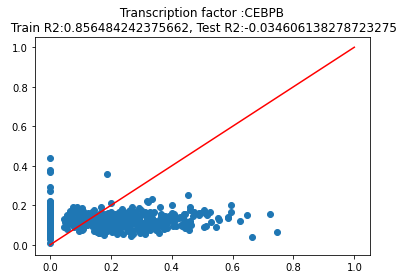

CEBPZ
True


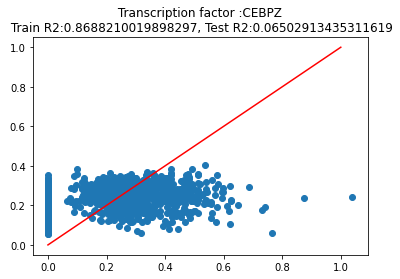

E2F4
True


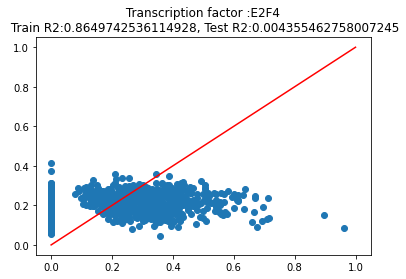

ELK1
True


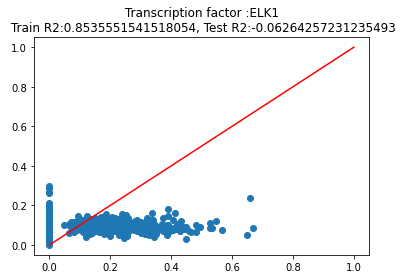

ELK4
True


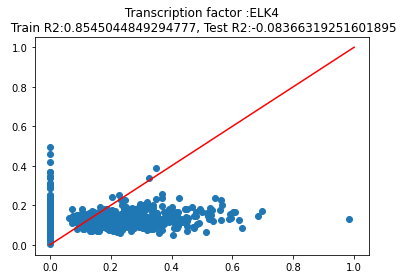

ESR1
True


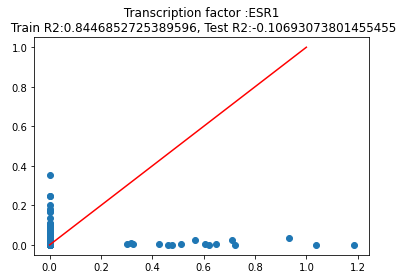

ETS1
True


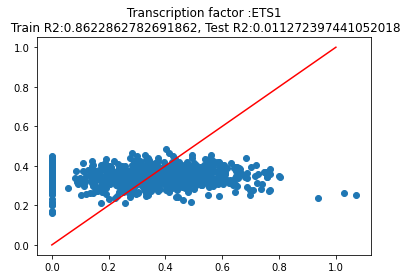

FOS
True


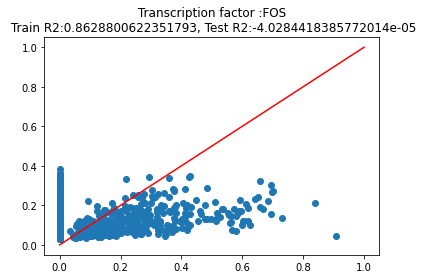

FOSL1
True


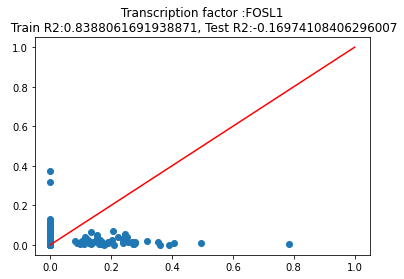

FOSL2
True


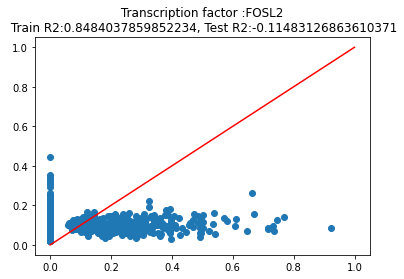

GABPA
True


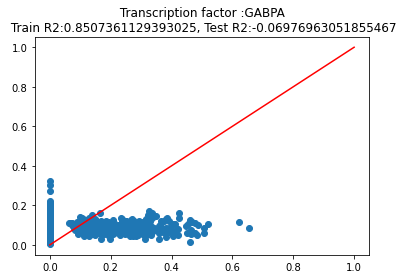

GATA1
True


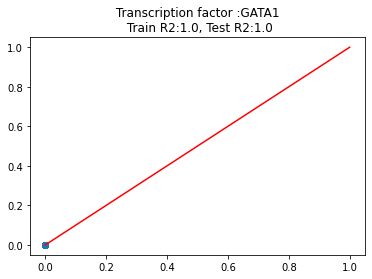

GATA2
True


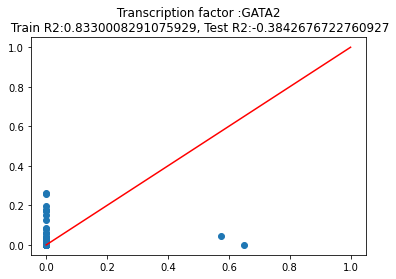

HSF1
HSF1 could not be fit

IRF3
True


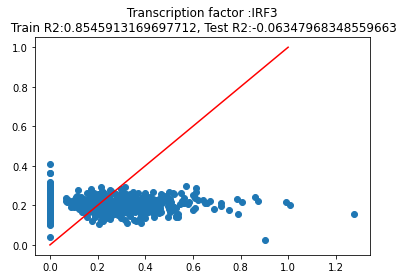

JUN
True


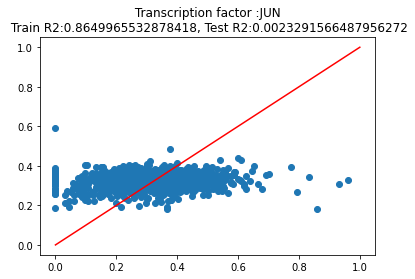

JUND
True


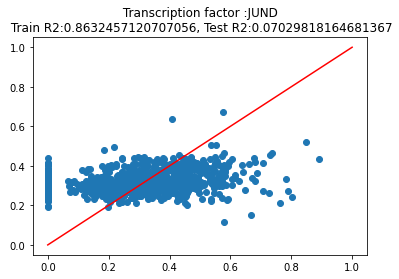

MEF2A
True


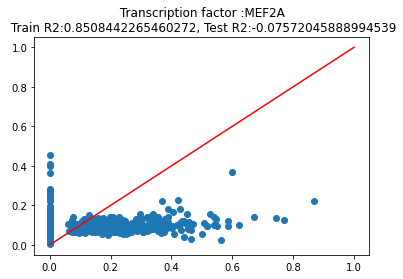

MEF2C
True


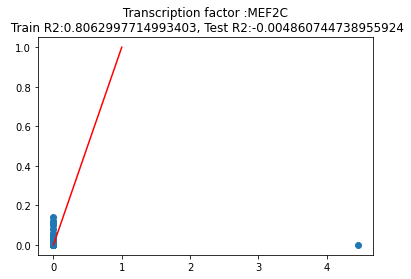

MYC
True


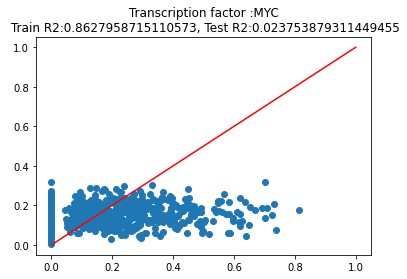

NANOG
True


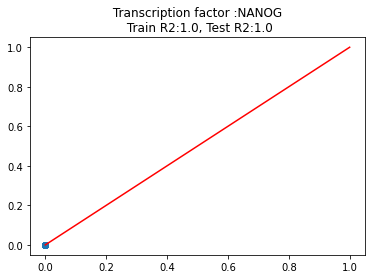

NFAT
True


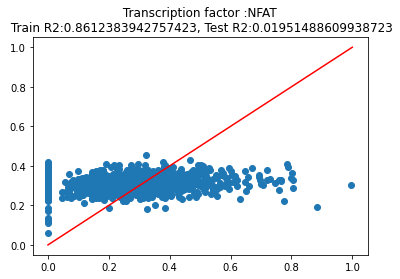

NFATC1
True


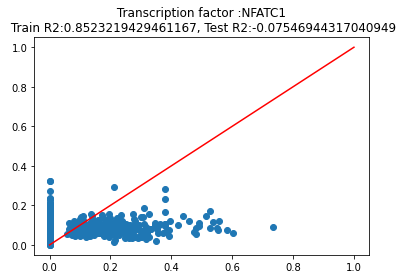

REST
True


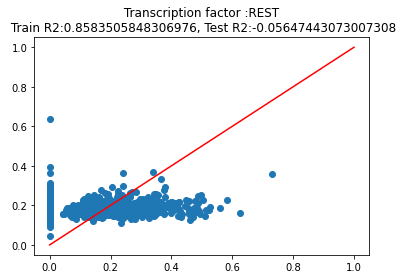

RXRA


In [ ]:
rf_dict, unfit_rf = fit_random_forest(TFs = TFs,
                                      predictors=predictors,
                                      expression_train=expression_training_sc,
                                      expression_valid=expression_validation_sc, plot = True)

In [ ]:
plt.close("all")

In [ ]:
rf_dict_noise, unfit_rf_noise = fit_random_forest(TFs = TFs,
                                      predictors=predictors,
                                      expression_train=expression_training_noise,
                                      expression_valid=expression_validation_noise)

In [ ]:
def fit_linear_regression(TFs, predictors, expression_train, expression_valid, plot = False):
    """ Fit a random forest to each TF and create a dictionary to save the results."""
    score_dict = {}
    unfit = []
    for tf in TFs:
        print(tf)
        rf = LinearRegression()


        try:
            # Train the forest
            rf.fit(X = expression_train[predictors],
                   y = expression_train[tf])
            
        except BaseException as e:
            print(f"{tf} could not be fit")
            print(e)
            unfit.append(tf)
            continue

        ## For each model that was fit: predict and assess fit on the training and validation set
        ypred_test = rf.predict(expression_valid[predictors])
        ypred_train = rf.predict(expression_train[predictors])



        score_train = r2_score(y_true=expression_train[tf],
                                             y_pred = ypred_train)
        score_test = r2_score(y_true=expression_valid[tf],
                                             y_pred = ypred_test)
        score_dict[tf] = (score_train, score_test)

        if plot:
            plt.figure()
            plt.scatter(x = nonzeroTF_test[tf], y = ypred_test)
            X = np.linspace(0,1)
            plt.plot( X, X, "r")
            plt.title( f" TF:{tf}, Train R2:{score_train}, Test R2:{score_test}")
        else:
            print(f" TF:{tf}, Train R2:{score_train}, Test R2:{score_test}")




    return(score_dict, unfit)

In [ ]:
linreg_dict, unfit_linreg = fit_linear_regression(TFs = TFs,
                                      predictors=predictors,
                                      expression_train=expression_training_sc,
                                      expression_valid=expression_validation_sc, plot=True)

In [ ]:
linreg_dict_noise, unfit_linreg_noise = fit_linear_regression(TFs = TFs,
                                      predictors=predictors,
                                      expression_train=expression_training_noise,
                                      expression_valid=expression_validation_noise)